In [1]:
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
mx.random.seed(1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\h5py\tests\old\test_attrs_data.py:251: DeprecationWarning: invalid escape sequence \H
  s = b"Hello\x00\Hello"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\func_inspect.py:53: DeprecationWarning: invalid escape sequence \<
  '\<doctest (.*\.rst)\[(.*)\]\>', source_file).groups()
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_memory_helpers.py:10: DeprecationWarning: invalid escape sequence \s
  cookie_re = re.compile("coding[:=]\s*([-\w.]+)")


In [2]:
data_ctx=mx.gpu()
model_ctx=mx.gpu()
ctx=mx.gpu()

In [54]:
# 创建训练集iter
train_iter = mx.io.ImageRecordIter(
    path_imgrec="image_data_train.rec", 
    data_shape=(3,200,200),                                        
    batch_size=10,
    scale=1/255
)

# 创建内部测试集iter
val_iter = mx.io.ImageRecordIter(
    path_imgrec="image_data_test.rec",
    data_shape=(3,200,200),
    batch_size=10,
    scale=1/255
)

DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]


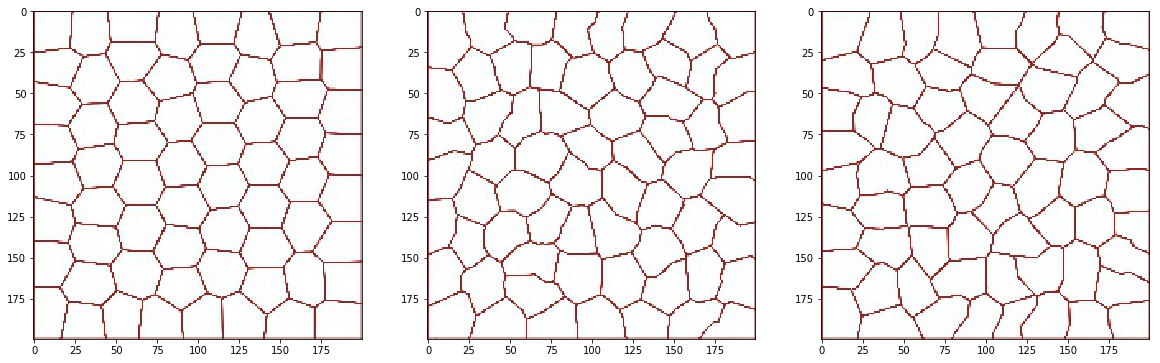

In [6]:
from matplotlib import pyplot as plt
batch = train_iter.next() #
print(batch) 

data = batch.data[0]
fig=plt.figure(0,figsize=(20,20))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
    
plt.show()

In [7]:
batch_size=50
num_outputs=4
    

In [ ]:
train_iter.reset()
for data in train_iter:
    print(data)

In [16]:
train_iter.reset()
for i,batch in enumerate(train_iter):
    print(batch)

DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch: data shapes: [(10, 3, 200, 200)] label shapes: [(10,)]
DataBatch:

In [52]:
train_iter.reset()
test=train_iter.next()
#print(test.data)
label=test.data
label=label[0].as_in_context(ctx)
print(label[0])


[[[0.69803923 0.6627451  0.52156866 ... 0.54509807 0.5803922  0.5882353 ]
  [0.64705884 1.         1.         ... 1.         1.         0.8705883 ]
  [0.5294118  1.         0.93725497 ... 0.97647065 1.         0.7568628 ]
  ...
  [0.53333336 1.         0.97647065 ... 1.         1.         0.76470596]
  [0.5882353  1.         1.         ... 1.         1.         0.81568635]
  [0.58431375 0.8588236  0.76470596 ... 0.7607844  0.8196079  0.65882355]]

 [[0.10196079 0.2392157  0.2627451  ... 0.2627451  0.25490198 0.20784315]
  [0.22352943 0.9215687  0.97647065 ... 0.96470594 0.9333334  0.62352943]
  [0.27058825 0.97647065 1.         ... 1.         0.98823535 0.63529414]
  ...
  [0.2509804  0.96470594 1.         ... 1.         0.9843138  0.6431373 ]
  [0.27058825 0.93725497 0.98823535 ... 0.98823535 0.95294124 0.6431373 ]
  [0.20392159 0.6117647  0.6431373  ... 0.6392157  0.64705884 0.42352945]]

 [[0.09803922 0.2392157  0.26666668 ... 0.26666668 0.2392157  0.18039216]
  [0.22352943 0.92156

In [56]:
num_fc=128
net=gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20,kernel_size=5,activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2,strides=2))
    net.add(gluon.nn.Conv2D(channels=50,kernel_size=5,activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2,strides=2))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc,activation='relu'))
    net.add(gluon.nn.Dense(num_outputs))

In [57]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24),ctx=ctx)

In [58]:
softmax_cross_entropy=gluon.loss.SoftmaxCrossEntropyLoss()

In [59]:
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':.1})

In [60]:
def evaluate_accuracy(data_iterator,net):
    acc=mx.metric.Accuracy()
    for batch in (data_iterator):
        data=batch.data[0].as_in_context(ctx)
        label=batch.label[0].as_in_context(ctx)
        output=net(data)
        predictions=nd.argmax(output,axis=1)
        #print(predictions)
        #print(label)
        acc.update(preds=predictions,labels=label)
    return acc.get()[1]

In [ ]:
epochs=10
smoothing_constant=0.1
for e in range(epochs):
    train_iter.reset()
    val_iter.reset()
    for i, batch in enumerate(train_iter):
        data=batch.data[0].as_in_context(ctx)
        #print(data[0])
        label=batch.label[0].as_in_context(ctx)
        with autograd.record():
            output=net(data)
            loss=softmax_cross_entropy(output,label)
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss=nd.mean(loss).asscalar()
        #print(net(data))
        moving_loss=(curr_loss if ((i==0) and (e==0))
                     else(1-smoothing_constant)*moving_loss+smoothing_constant*curr_loss)
    train_iter.reset()
    test_accuracy=evaluate_accuracy(val_iter,net)
    train_accuracy=evaluate_accuracy(train_iter,net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %(e, moving_loss,train_accuracy,test_accuracy))

Epoch 0. Loss: 1.4036679002207193, Train_acc 0.24742268041237114, Test_acc 0.256
Epoch 1. Loss: 1.3904974822848568, Train_acc 0.2556701030927835, Test_acc 0.22916666666666666
Epoch 2. Loss: 1.3899471192114725, Train_acc 0.25463917525773194, Test_acc 0.23333333333333334
Epoch 3. Loss: 1.389829772597854, Train_acc 0.25463917525773194, Test_acc 0.23333333333333334
Epoch 4. Loss: 1.390654095376381, Train_acc 0.25416666666666665, Test_acc 0.22916666666666666
Epoch 5. Loss: 1.3912997681061443, Train_acc 0.24742268041237114, Test_acc 0.256
Epoch 6. Loss: 1.3904757874292442, Train_acc 0.2556701030927835, Test_acc 0.22916666666666666
Epoch 7. Loss: 1.389947858820569, Train_acc 0.25463917525773194, Test_acc 0.23333333333333334
Epoch 8. Loss: 1.3898296346082586, Train_acc 0.25463917525773194, Test_acc 0.23333333333333334
